# Text to Image generation on SageMaker

**PreRequisite** 
You will need a huggingface account to do this tutorial.

In this notebook, you will learn how you can fine-tune an existing Stable Diffusion model on SageMaker and deploy it for inference.

## 0. Setup

In [72]:
import multiprocessing as mp
import torch
import subprocess
import os
!./process.sh

  docker.socket
1
SageMaker instance route table setup is ok. We are good to go.
1
SageMaker instance routing for Docker is ok. We are good to go!
Region is not set, using default config. To set use -r flag
Account Num is not set, using default for us-east-1 which is 763104351884 to set use -a flag
Region is us-east-1
AcctNum is 763104351884
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
/home/ec2-user/SageMaker/n

In [2]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.huggingface import HuggingFace
from sagemaker import get_execution_role

This notebook is purely educational for showing how to fine-tune latent-stable-diffusion on Amazon SageMaker. Neither the images produced or code represent Amazon or its views in any way shape or form. To properly leverage this codebase, read the corresponding licenses from [CompVis](https://huggingface.co/spaces/CompVis/stable-diffusion-license) (the model) and [Conceptual Captions](https://huggingface.co/datasets/conceptual_captions) (from Google, but you will use HF)

This demo requires a g5.12xlarge or more powerful instance.

Model weights were provided by CompVis/stable-diffusion-v1-4. You can find the licensing, README and more [here](https://huggingface.co/CompVis/stable-diffusion-v1-4). To download the weights, you will need to have a huggingface account, accept the terms on the aforementioned link, then generate your user authenticated token. These steps are beyond the scope of this Notebook. Please note that the finetune.py script has been slightly modified from a PR request [here](https://github.com/huggingface/diffusers/pull/356)

You will install some libraries so that you can use stable-diffusion locally.

In [3]:
!pip install diffusers -q

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install transformers==4.21.0 -q
!pip install ftfy spacy -q

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


## 1. Download Model and Data
Now you will download the model first.

In [5]:
import torch
import os
from diffusers import DiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
token_value = 'INSERT TOKEN HERE'
force = False
if os.path.exists('sd-base-model') and (not force):
    d = './sd-base-model/'
else:
    d = "CompVis/stable-diffusion-v1-4"
    
model = DiffusionPipeline.from_pretrained(d, cache_dir=os.path.join(os.getcwd(),'base-model'),use_auth_token=token_value)

if d == "CompVis/stable-diffusion-v1-4":
    d = './sd-base-model'
    !rm -rf sd-base-model
    model.save_pretrained('./sd-base-model/')
    !rm -rf ./base-model

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

{'trained_betas'} was not found in config. Values will be initialized to default values.


And the dataset.

In [6]:
!pip install datasets -q

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [7]:
from datasets import load_dataset

data_name = 'conceptual_captions'

In [8]:
!rm -rf conceptual_captions
dataset = load_dataset("conceptual_captions")
!mkdir {data_name}
!cp -r ./sd-base-model {data_name}

No config specified, defaulting to: conceptual_captions/unlabeled


Generating train split:   0%|          | 0/3318333 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15840 [00:00<?, ? examples/s]

Dataset conceptual_captions downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
#feel free to visualize the dataset below

In [10]:
df = dataset['train'].to_pandas()
df.head()

,image_url,caption
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .


This following cell will allow you to download the images (not provided in the previous download), and extract a subset for training.

In [11]:
import pandas as pd
from PIL import Image

df = dataset['train'].to_pandas()
def download_file(url,index):
    import urllib.request
    urllib.request.urlretrieve(url,f'./{data_name}/{index}.jpg')
j = 0
indexes = []
images = set()
for i in range(len(df)):
    try:
        df.loc[i,'sm_key'] = f'/opt/ml/input/data/training/{j}.jpg'
        df.loc[i,'local_key'] = f'{j}.jpg'
        download_file(df.loc[i,'image_url'],j)
        img = Image.open(f'./conceptual_captions/{j}.jpg')
        j += 1
        indexes.append(i)
    except Exception as e:
        print(f"file didn't download will continue {i}")
        print(e)
            
    if (j % 100 == 0) and (j>0):#You can change this to train on a larger dataset
        break
df = df.iloc[indexes,:]
df.to_parquet(f'./{data_name}/dataset.parquet')

file didn't download will continue 9
HTTP Error 403: Forbidden
file didn't download will continue 11
HTTP Error 503: Service Unavailable
file didn't download will continue 12
<urlopen error [Errno -2] Name or service not known>
file didn't download will continue 17
HTTP Error 404: Not Found
file didn't download will continue 18
HTTP Error 403: Forbidden
file didn't download will continue 20
HTTP Error 404: Not Found
file didn't download will continue 24
HTTP Error 404: Not Found
file didn't download will continue 32
HTTP Error 404: Not Found
file didn't download will continue 40
<urlopen error [Errno -2] Name or service not known>
file didn't download will continue 51
HTTP Error 404: Not Found
file didn't download will continue 57
HTTP Error 403: Forbidden
file didn't download will continue 79
HTTP Error 406: Not Acceptable
file didn't download will continue 88
HTTP Error 406: Not Acceptable
file didn't download will continue 97
cannot identify image file './conceptual_captions/84.jpg'

In [12]:
#Again feel free to run the following two cells to visualize a sample from the dataset.

In [13]:
from datasets import load_dataset

d = load_dataset('parquet',data_dir=f'./{data_name}',data_files='dataset.parquet')

Using custom data configuration default-51c81f400e9df2fa


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/parquet/default-51c81f400e9df2fa/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

0.jpg
a very typical bus station


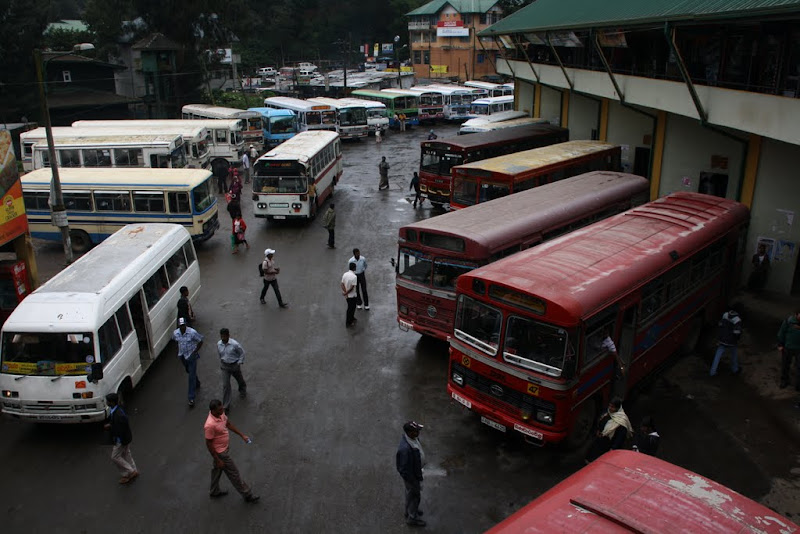

In [14]:
from PIL import Image

idx = 0
img,text = d['train'][idx]['local_key'],d['train'][idx]['caption']
print(img)
print(text)
Image.open(f'./{data_name}/{img}')

Additionally, the data you will be using comes from mscoco. However, you can also download from [here](https://huggingface.co/datasets/ChristophSchuhmann/MS_COCO_2017_URL_TEXT) which uses the dataset from [here](https://academictorrents.com/details/74dec1dd21ae4994dfd9069f9cb0443eb960c962). Then use this [link](https://github.com/rom1504/img2dataset) to quickly fill in the datasets files. For the purpose of this notebook you can download a few samples using the cell below.

# 2. Training
You will use distributed training, to do so you need to leverage any existing GPU's. The first cell will evaluate to see how many gpus are on the current system.

In [15]:
import subprocess
processes_per_host = subprocess.Popen("nvidia-smi -q | awk '/Attached GPUs/ {print $4}'",
                              shell=True,
                              stdout=subprocess.PIPE)
processes_per_host = int(processes_per_host.stdout.read().decode().strip())
print(processes_per_host)

4


The following cell will enable you to build an estimator for training locally, and fit on the local dataset you previously built.

In [16]:
import os
from sagemaker.huggingface import HuggingFace
from sagemaker.local import LocalSession
from sagemaker import get_execution_role

est = HuggingFace(
    entry_point='finetune.py',
    source_dir='src',
    image_uri='763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.12.1-gpu-py38-cu113-ubuntu20.04-sagemaker',
    #pytorch_version="1.10.2",
    #transformers_version="4.17.0",
    sagemaker_session=LocalSession(),
    role=get_execution_role(),
    instance_type='local_gpu',
    output_path='file://{}'.format(os.path.join(os.getcwd(),'model')),
    py_version='py38',
    base_job_name='test',
    instance_count=1,
    hyperparameters={
        'pretrained_model_name_or_path':'/opt/ml/input/data/training/sd-base-model',
        'dataset_name':'/opt/ml/input/data/training/dataset.parquet',
        'caption_column':'caption',
        'image_column':'sm_key',
        'resolution':256,
        'mixed_precision':'fp16',
        'train_batch_size':2,
        'learning_rate': '1e-10',
        'max_train_steps':100,
        'num_train_epochs':1,
        'output_dir':'/opt/ml/model/sd-output-final',   
    },
    distribution={"mpi":{"enabled":True,"processes_per_host":processes_per_host}} if processes_per_host>1 else {}
)

In [17]:
#Please note training can take upwards of 25 minutes (13 minutes for saving the model). 

In [18]:
est.fit(f'file://./{data_name}/')

Creating 1x4fc011ay-algo-1-nrgii ... 
Creating 1x4fc011ay-algo-1-nrgii ... done
Attaching to 1x4fc011ay-algo-1-nrgii
1x4fc011ay-algo-1-nrgii | 2022-10-05 21:27:04,795 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
1x4fc011ay-algo-1-nrgii | 2022-10-05 21:27:04,835 sagemaker-training-toolkit INFO     instance_groups entry not present in resource_config
1x4fc011ay-algo-1-nrgii | 2022-10-05 21:27:04,835 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
1x4fc011ay-algo-1-nrgii | 2022-10-05 21:27:04,844 sagemaker_pytorch_container.training INFO     Invoking user training script.
1x4fc011ay-algo-1-nrgii | 2022-10-05 21:27:04,889 botocore.credentials INFO     Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
1x4fc011ay-algo-1-nrgii | 2022-10-05 21:27:05,058 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
1x4fc011ay-algo-1-nrgii | /opt/conda/bin/python3.8 -m p

The "Aborting on container exit" line may hang for up to 15 minutes due to the size of the model being compressed, saved, and uploaded.

In [19]:
print(est.model_data) #In case you have to restart kernel.

file:///home/ec2-user/SageMaker/nlp-summit/sagemaker-distributed-training-workshop/4_bonus_text2img_end2end/model/model.tar.gz


## 3. Inference
Prior to doing inference you will need to extand an existing Deep Learning Container. Feel free to look at Dockerfile-Inf under the src directory for more details on this file. Otherwise, this following cell will build a local container for use in this notebook.

Define your Model for deployment (This can be skipped due to the previous train job).

In [103]:
from sagemaker.huggingface import HuggingFaceModel
from sagemaker.local import LocalSession
from sagemaker.session import Session
import os
deploy_remote = False # if you set this to true you will deploy to a remote endpoint.
if deploy_remote :
    bucket = LocalSession().default_bucket()
    !aws s3 cp ./model/model.tar.gz s3://{bucket}/sd/model.tar.gz
    !./src/push_to_ecr.sh
    model_data = 's3://{}/sd/model.tar.gz'.format(bucket)
    
    with open('output.txt','r') as f:
        image_name = f.read().strip()
    print(image_name)

    sess = Session()
else:
    model_data = est.model_data
    sess = LocalSession()
    image_name = 'local:latest'
#This cell could be done separately, and you could deploy the following one directly.
## However, if you happen to restart later, this cell will run but you will need to input
##  est.model_data into model_data =
est=HuggingFaceModel(role=get_execution_role(),
                     py_version='py38',
                     model_data=model_data,
                     image_uri=image_name,
                     sagemaker_session=sess,
                     model_server_workers=processes_per_host if not deploy_remote else 1
)

Deploy your model for inference!

In [104]:
pred = est.deploy(instance_type='local_gpu' if not deploy_remote else 'ml.g5.4xlarge',
                  initial_instance_count=1)

Attaching to 2590tzzhxi-algo-1-tyydn
2590tzzhxi-algo-1-tyydn | Warning: MMS is using non-default JVM parameters: -XX:-UseContainerSupport
2590tzzhxi-algo-1-tyydn | 2022-10-05T22:53:37,181 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
2590tzzhxi-algo-1-tyydn | MMS Home: /opt/conda/lib/python3.8/site-packages
2590tzzhxi-algo-1-tyydn | Current directory: /
2590tzzhxi-algo-1-tyydn | Temp directory: /home/model-server/tmp
2590tzzhxi-algo-1-tyydn | Number of GPUs: 4
2590tzzhxi-algo-1-tyydn | Number of CPUs: 96
2590tzzhxi-algo-1-tyydn | Max heap size: 27305 M
2590tzzhxi-algo-1-tyydn | Python executable: /opt/conda/bin/python3.8
2590tzzhxi-algo-1-tyydn | Config file: /etc/sagemaker-mms.properties
2590tzzhxi-algo-1-tyydn | Inference address: http://0.0.0.0:8080
2590tzzhxi-algo-1-tyydn | Management address: http://0.0.0.0:8080
2590tzzhxi-algo-1-tyydn | Model Store: /.sagemaker/mms/models
2590tzzhxi-algo-1-tyydn | Initial Models: ALL
2590tzzhxi-algo-1-tyydn | Log dir: null
2590tzzhxi-algo-1-ty

Provide prompts for training. The first text argument is based on this current dataset.

In [105]:
prompts = [text,'A photo of an astronaut riding a horse on mars', 
           'A dragonfruit wearing karate belt in the snow.', 
           'Teddy bear swimming at the Olympics 400m Butter-fly event.',
           'A cute sloth holding a small glowing treasure chest.']

In [106]:
#Get the outputs

For more parameters feel free to explore [here](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion)

In [107]:
outputs = [pred.predict({'inputs':prompt,
                         'parameters':{'guidance_scale':10}})
           for prompt in prompts]

2590tzzhxi-algo-1-tyydn | 2022-10-05T22:53:53,024 [INFO ] W-9000-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - Model model loaded io_fd=0242acfffe140002-0000008e-00000004-1105b7e549fabe90-d0990266
2590tzzhxi-algo-1-tyydn | 2022-10-05T22:53:53,025 [INFO ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 15655
2590tzzhxi-algo-1-tyydn | 2022-10-05T22:53:53,028 [WARN ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerLifeCycle - attachIOStreams() threadName=W-model-1
2590tzzhxi-algo-1-tyydn | 2022-10-05T22:53:53,528 [WARN ] W-model-1-stderr com.amazonaws.ml.mms.wlm.WorkerLifeCycle - 
2590tzzhxi-algo-1-tyydn | 2022-10-05T22:53:53,705 [INFO ] W-9000-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - Model model loaded io_fd=0242acfffe140002-0000008e-00000000-1fbfd7e549fabe90-8bc70901
2590tzzhxi-algo-1-tyydn | 2022-10-05T22:53:53,706 [INFO ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 16336
2590tzzhxi-algo-1-tyydn | 2022-10-

In [108]:
outputs = [output['images'][0] for output in outputs]

In [109]:
def process_result(out):
    from PIL import Image
    from io import BytesIO
    import base64
    return Image.open(BytesIO(base64.b64decode(out)))

In [110]:
images = [[process_result(output),prompt] for output,prompt in zip(outputs,prompts)]

In [111]:
#Visualize the results from the inference

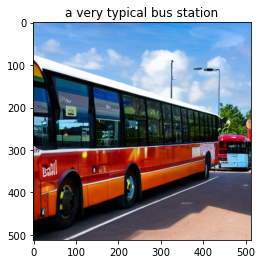

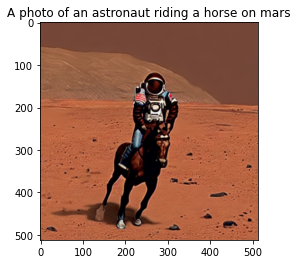

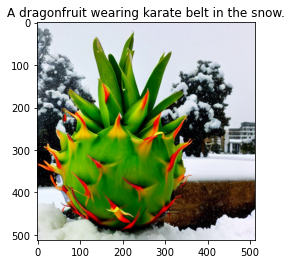

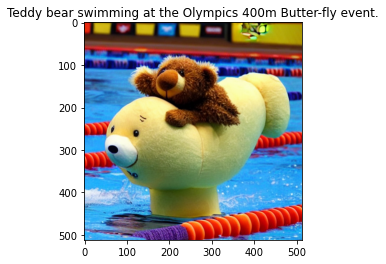

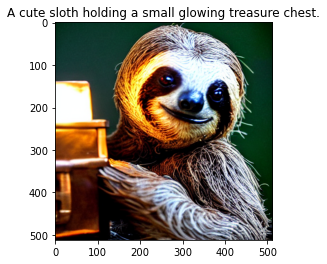

In [112]:
import matplotlib.pyplot as plt

for i in range(len(images)):
    plt.figure()
    plt.title(images[i][1])
    plt.imshow(images[i][0])

In [ ]:
# clean up your endpoint
pred.delete_endpoint()

## 4. (Bonus) compare against the original model.

Using the previous model that you defined as a base model, you can also evaluate it locally.

In [ ]:
import torch
if torch.cuda.is_available():
    model = model.to('cuda:0')

In [ ]:
outs = [model(prompt) for prompt in prompts]

In [ ]:
#visualize output

In [ ]:
for i in range(len(outs)):
    plt.figure()
    plt.title(prompts[i])
    plt.imshow(outs[i].images[0])

In [ ]:
#You will need to reset the kernel to remove the model from the GPU Memory if you wish to train more locally.